### NOAA ETSS Beautiful Soup Web Scraper
#### The first step utilizes the requests library to issue an HTTP get request.
#### This will retrieve the html data and store it in python for use.

In [110]:
import requests
from bs4 import BeautifulSoup

URL = "https://slosh.nws.noaa.gov/etsurge/index.php?page=stn&region=gm&datum=msl&list=&map=0-48&type=text&stn=flpete"
page = requests.get(URL)

print(page.text)
soup = BeautifulSoup(page.content, "html.parser") 

<!DOCTYPE html>
<html lang="en" xmlns="https://www.w3.org/1999/xhtml">
<head>
  <SCRIPT LANGUAGE="JavaScript"><!-- Hide script
// End hide -->
</SCRIPT>
  <title>ETSS stn</title>
  <meta name="DC.title" content="Extra-Tropical Storm Surge">
  <meta name="DC.description" content="Extra-Tropical Storm Surge landing page">
  <meta name="DC.creator" content="NWS/Meteorological Development Lab">
  <meta name="DC.language" scheme="DCTERMS.RFC1766" content="EN-US">
  <meta name="rating" content="general">
  <meta name="resource-type" content="document">
  <meta name="distribution" content="global">
  <meta http-equiv="Window-target" content="_top">
  <meta charset="iso-8859-1">
  <base target="_self">

  <link rel="stylesheet" type="text/css" href="ss/ssMain.css">
  <meta name="Keywords" content="etsurge, extra tropical storm surge, extra-tropical storm surge, extratropcial storm surge, storm surge, SLOSH">

  <link rel="stylesheet" type="text/css" href="etsurge2.0main.css"/>
  <link rel="sty

In [111]:
# Scrape the wrapper2 id to help reduce the amount of data.
#results = soup.find(id="wrapper2")
#print(results.prettify)

In [112]:
# Extract the content between the <pre> tags
pre_content = soup.find('pre').get_text()

# Output the NOAA etss data table 
print(pre_content)

#Saint Petersburg, FL : 10/25/2024 12:20:20 GMT (units in feet MSL)
#Date(GMT), Surge,   Tide,    Obs,   Fcst,   Anom, Comment
#------------------------------------------------------------
10/23 12Z,   0.30,   0.97,   1.44,  99.90,   0.17,
10/23 13Z,   0.30,   0.62,   1.10,  99.90,   0.18,
10/23 14Z,   0.30,   0.22,   0.63,  99.90,   0.11,
10/23 15Z,   0.30,  -0.20,   0.14,  99.90,   0.04,
10/23 16Z,   0.30,  -0.58,  -0.29,  99.90,  -0.01,
10/23 17Z,   0.30,  -0.87,  -0.62,  99.90,  -0.05,
10/23 18Z,   0.40,  -1.03,  -0.76,  99.90,  -0.13,  (min)
10/23 19Z,   0.40,  -1.04,  -0.70,  99.90,  -0.06,
10/23 20Z,   0.40,  -0.91,  -0.48,  99.90,   0.03,
10/23 21Z,   0.40,  -0.70,  -0.20,  99.90,   0.10,
10/23 22Z,   0.40,  -0.44,   0.10,  99.90,   0.14,
10/23 23Z,   0.40,  -0.17,   0.39,  99.90,   0.16,
10/24 00Z,   0.40,   0.07,   0.64,  99.90,   0.17,
10/24 01Z,   0.40,   0.26,   0.82,  99.90,   0.16,
10/24 02Z,   0.30,   0.41,   0.89,  99.90,   0.18,
10/24 03Z,   0.30,   0.51,   0.98,  99.

### Now let's create a pandas dataframe from the data. This will allow us to calculate and plot parameters
#### All values of 99.90 have been replaced with NaN. NOAA's dataset should be examined to understand 99.90 values.


In [113]:
import pandas as pd
import numpy as np

# Split the NOAA pre_content from the ETSS website
lines = pre_content.splitlines()

# Filter out comments and empty lines (lines start with '#')
data_lines = [line for line in lines if not line.startswith('#') and line.strip()]

# Split each valid line by commas and remove extra spaces
data = [line.split(',') for line in data_lines]

# Create Pandas DataFrame from the extracted data
columns = ['Date(GMT)', 'Surge', 'Tide', 'Obs', 'Fcst', 'Anom', 'Comment']
df = pd.DataFrame(data, columns=columns)

# Apply strip to all string cells in the DataFrame
df = df.apply(lambda col: col.map(lambda x: x.strip() if isinstance(x, str) else x))

# Convert numeric columns to appropriate data types
df[['Surge', 'Tide', 'Obs', 'Fcst', 'Anom']] = df[['Surge', 'Tide', 'Obs', 'Fcst', 'Anom']].astype(float)

# Replace any value equal to 99.90 with NaN
df.replace(99.90, np.nan, inplace=True)

# Print df
print(df)

     Date(GMT)  Surge  Tide   Obs  Fcst  Anom Comment
0    10/23 12Z    0.3  0.97  1.44   NaN  0.17        
1    10/23 13Z    0.3  0.62  1.10   NaN  0.18        
2    10/23 14Z    0.3  0.22  0.63   NaN  0.11        
3    10/23 15Z    0.3 -0.20  0.14   NaN  0.04        
4    10/23 16Z    0.3 -0.58 -0.29   NaN -0.01        
..         ...    ...   ...   ...   ...   ...     ...
128  10/28 20Z    0.3  0.09   NaN  0.61  0.21        
129  10/28 21Z    0.3 -0.22   NaN  0.30  0.21        
130  10/28 22Z    0.4 -0.41   NaN  0.20  0.21        
131  10/28 23Z    0.4 -0.44   NaN  0.18  0.21   (min)
132  10/29 00Z    0.5 -0.29   NaN  0.43  0.21        

[133 rows x 7 columns]


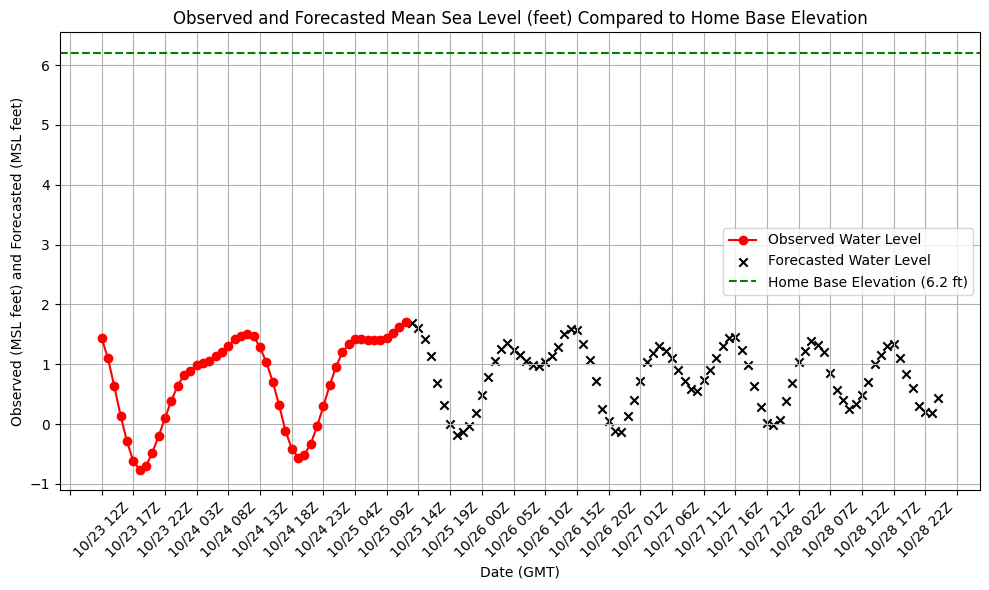

In [114]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Set the home base elevation value (MSL ft)
home_base_elev = 6.2

# Plot data on figure (x) vs (y)
plt.figure(figsize=(10, 6))

# X values will be 'Date(GMT)' and Y values will be 'Obs'
plt.plot(df['Date(GMT)'], df['Obs'], marker='o', linestyle='-', color='r', label='Observed Water Level')
# Add Fcst values as black 'X' markers
plt.scatter(df['Date(GMT)'], df['Fcst'], color='black', marker='x', label='Forecasted Water Level')
# Add a horizontal line at y = home_base_elev
plt.axhline(y=home_base_elev, color='g', linestyle='--', label=f'Home Base Elevation ({home_base_elev} ft)')

# Formatting the plot
plt.xlabel('Date (GMT)')
plt.ylabel('Observed (MSL feet) and Forecasted (MSL feet)')
plt.title('Observed and Forecasted Mean Sea Level (feet) Compared to Home Base Elevation')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
# Reducing the number of dates/times on the x-axis
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=30))  # Limit to 6 x-axis labels

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()


In [115]:
print(df)

     Date(GMT)  Surge  Tide   Obs  Fcst  Anom Comment
0    10/23 12Z    0.3  0.97  1.44   NaN  0.17        
1    10/23 13Z    0.3  0.62  1.10   NaN  0.18        
2    10/23 14Z    0.3  0.22  0.63   NaN  0.11        
3    10/23 15Z    0.3 -0.20  0.14   NaN  0.04        
4    10/23 16Z    0.3 -0.58 -0.29   NaN -0.01        
..         ...    ...   ...   ...   ...   ...     ...
128  10/28 20Z    0.3  0.09   NaN  0.61  0.21        
129  10/28 21Z    0.3 -0.22   NaN  0.30  0.21        
130  10/28 22Z    0.4 -0.41   NaN  0.20  0.21        
131  10/28 23Z    0.4 -0.44   NaN  0.18  0.21   (min)
132  10/29 00Z    0.5 -0.29   NaN  0.43  0.21        

[133 rows x 7 columns]


In [116]:
# Add Columns Barrier_HeightObs and Barrier_HeightFcst to df
df['Barrier_HeightObs'] = df['Obs'] - home_base_elev
df['Barrier_HeightFcst'] = df['Fcst'] - home_base_elev

In [117]:
print(df)

     Date(GMT)  Surge  Tide   Obs  Fcst  Anom Comment  Barrier_HeightObs  \
0    10/23 12Z    0.3  0.97  1.44   NaN  0.17                      -4.76   
1    10/23 13Z    0.3  0.62  1.10   NaN  0.18                      -5.10   
2    10/23 14Z    0.3  0.22  0.63   NaN  0.11                      -5.57   
3    10/23 15Z    0.3 -0.20  0.14   NaN  0.04                      -6.06   
4    10/23 16Z    0.3 -0.58 -0.29   NaN -0.01                      -6.49   
..         ...    ...   ...   ...   ...   ...     ...                ...   
128  10/28 20Z    0.3  0.09   NaN  0.61  0.21                        NaN   
129  10/28 21Z    0.3 -0.22   NaN  0.30  0.21                        NaN   
130  10/28 22Z    0.4 -0.41   NaN  0.20  0.21                        NaN   
131  10/28 23Z    0.4 -0.44   NaN  0.18  0.21   (min)                NaN   
132  10/29 00Z    0.5 -0.29   NaN  0.43  0.21                        NaN   

     Barrier_HeightFcst  
0                   NaN  
1                   NaN  
2        

In [118]:
# Create Barrier_Height column that checks if Barrier_HeightObs or Barrier_HeightFcst are greater than zero, if true print the positive number, if not NaN
df['Barrier_HeightReq'] = np.where(df['Barrier_HeightObs'] > 0, df['Barrier_HeightObs'],
                        np.where(df['Barrier_HeightFcst'] > 0, df['Barrier_HeightFcst'], np.nan))
print(df)

     Date(GMT)  Surge  Tide   Obs  Fcst  Anom Comment  Barrier_HeightObs  \
0    10/23 12Z    0.3  0.97  1.44   NaN  0.17                      -4.76   
1    10/23 13Z    0.3  0.62  1.10   NaN  0.18                      -5.10   
2    10/23 14Z    0.3  0.22  0.63   NaN  0.11                      -5.57   
3    10/23 15Z    0.3 -0.20  0.14   NaN  0.04                      -6.06   
4    10/23 16Z    0.3 -0.58 -0.29   NaN -0.01                      -6.49   
..         ...    ...   ...   ...   ...   ...     ...                ...   
128  10/28 20Z    0.3  0.09   NaN  0.61  0.21                        NaN   
129  10/28 21Z    0.3 -0.22   NaN  0.30  0.21                        NaN   
130  10/28 22Z    0.4 -0.41   NaN  0.20  0.21                        NaN   
131  10/28 23Z    0.4 -0.44   NaN  0.18  0.21   (min)                NaN   
132  10/29 00Z    0.5 -0.29   NaN  0.43  0.21                        NaN   

     Barrier_HeightFcst  Barrier_HeightReq  
0                   NaN                NaN

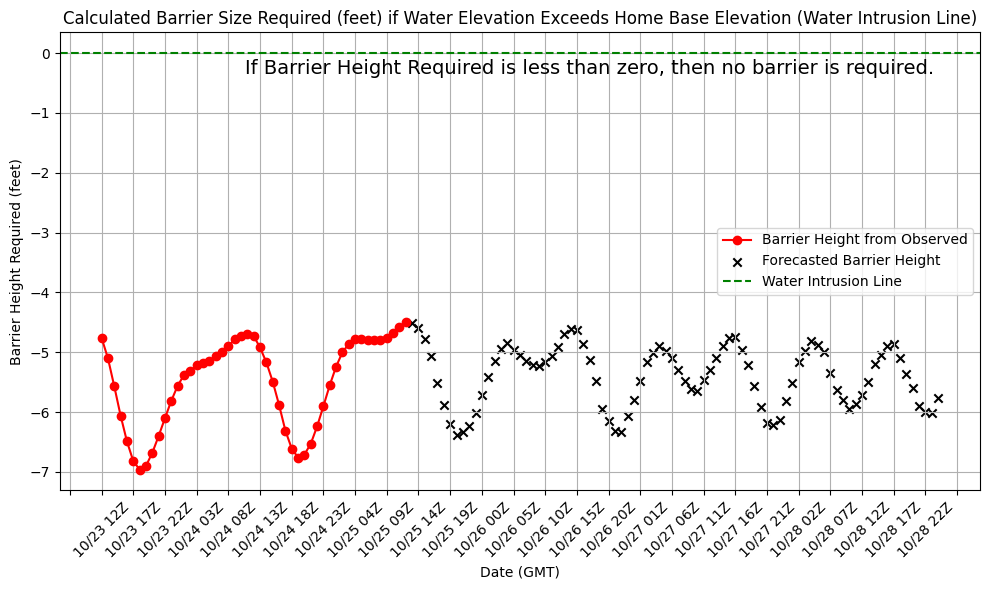

In [125]:
# Plot data on figure (x) vs (y)
plt.figure(figsize=(10, 6))

# X values will be 'Date(GMT)' and Y values will be 'Obs'
plt.plot(df['Date(GMT)'], df['Barrier_HeightObs'], marker='o', linestyle='-', color='r', label='Barrier Height from Observed')
# Add Fcst values as black 'X' markers
plt.scatter(df['Date(GMT)'], df['Barrier_HeightFcst'], color='black', marker='x', label='Forecasted Barrier Height')
# Add Barrier_HeightReq values as yellow 'o' markers
#plt.scatter(df['Date(GMT)'], df['Barrier_HeightReq'], color='black', marker='o', label='Barrier Height Required')

# Add a horizontal line at y = 0
plt.axhline(y=0, color='g', linestyle='--', label=f'Water Intrusion Line')

# Formatting the plot
plt.xlabel('Date (GMT)')
plt.ylabel('Barrier Height Required (feet)')
plt.title('Calculated Barrier Size Required (feet) if Water Elevation Exceeds Home Base Elevation (Water Intrusion Line)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
# Reducing the number of dates/times on the x-axis
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=30))  # Limit to 6 x-axis labels

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adding the note above the legend
plt.text(0.95, 0.92, "If Barrier Height Required is less than zero, then no barrier is required.",
         ha='right', va='center', transform=plt.gca().transAxes, fontsize=14, color='black')

# Display the plot
plt.tight_layout()
plt.show()